<a href="https://colab.research.google.com/github/ridhozahran/Harga-Minyak-Mentah-Menggunakan-Model-XGBoost/blob/main/UAS_BDDM_RIDHO_ZAHRAN_PRATAMA_22_11_4872.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NAMA : RIDHO ZAHRAN PRATAMA

NIM : 22.11.4872

KELAS : IF04

In [132]:
!pip install --upgrade scikit-learn xgboost

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

## Persiapan Dataset

In [134]:
data = pd.read_csv('/content/crude-oil-price.csv')
data.head()

,date,price,percentChange,change
0,1983-03-01 00:00:00+00:00,29.27,NaN,NaN
1,1983-04-01 00:00:00+00:00,30.63,4.646,1.36
2,1983-05-01 00:00:00+00:00,30.25,-1.241,-0.38
3,1983-06-01 00:00:00+00:00,31.38,3.736,1.13
4,1983-07-01 00:00:00+00:00,32.00,1.976,0.62


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           503 non-null    object 
 1   price          503 non-null    float64
 2   percentChange  502 non-null    float64
 3   change         502 non-null    float64
dtypes: float64(3), object(1)
memory usage: 15.8+ KB


In [136]:
data.describe()

,price,percentChange,change
count,503.000000,502.000000,502.000000
mean,46.508985,0.713873,0.087642
std,28.958951,10.434500,4.943837
min,10.420000,-54.245000,-32.830000
25%,20.460000,-5.292000,-1.735000
50%,33.820000,0.924500,0.260000
75%,69.670000,6.275750,2.377500
max,140.000000,88.376000,16.650000


## Pre-processing

In [137]:
# Mengubah kolom 'date' menjadi tipe datetime
data['date'] = pd.to_datetime(data['date'])

# Menetapkan 'date' sebagai indeks
data.set_index('date', inplace=True)

# Mengonversi kolom 'price' menjadi tipe numerik, dan menangani error dengan 'coerce'
data['price'] = pd.to_numeric(data['price'], errors='coerce')

# Menghapus baris yang memiliki nilai yang hilang
data.dropna(inplace=True)

# Menampilkan informasi deskriptif mengenai data harga
print(data['price'].describe())

count    502.000000
mean      46.543326
std       28.977584
min       10.420000
25%       20.450000
50%       34.525000
75%       69.780000
max      140.000000
Name: price, dtype: float64


In [138]:
# Missing Value
missing_values = data.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 price            0
percentChange    0
change           0
dtype: int64


In [139]:
# Fungsi untuk membuat fitur lagged
def create_features(data, lags):
    features = pd.DataFrame()
    for lag in range(1, lags + 1):
        features[f'lag_{lag}'] = data.shift(lag)
    return features

# Menentukan jumlah lag
lags = 5
features = create_features(data['price'], lags)
data_with_features = pd.concat([data, features], axis=1).dropna()

## Exploratory Data Analysis (EDA)

In [144]:
# Descriptive statistics
print(data['price'].describe())

count    502.000000
mean      46.543326
std       28.977584
min       10.420000
25%       20.450000
50%       34.525000
75%       69.780000
max      140.000000
Name: price, dtype: float64


                  price  percentChange    change
price          1.000000       0.060162  0.088228
percentChange  0.060162       1.000000  0.826563
change         0.088228       0.826563  1.000000


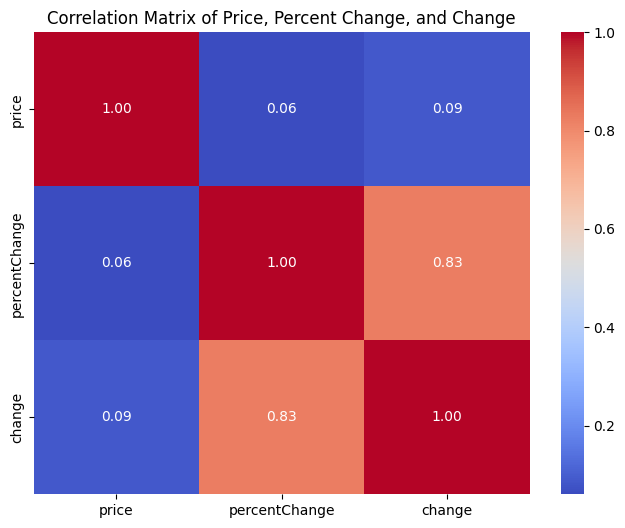

In [143]:
selected_data = data[['price', 'percentChange', 'change']]

correlation_matrix = selected_data.corr()

print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Price, Percent Change, and Change')
plt.show()

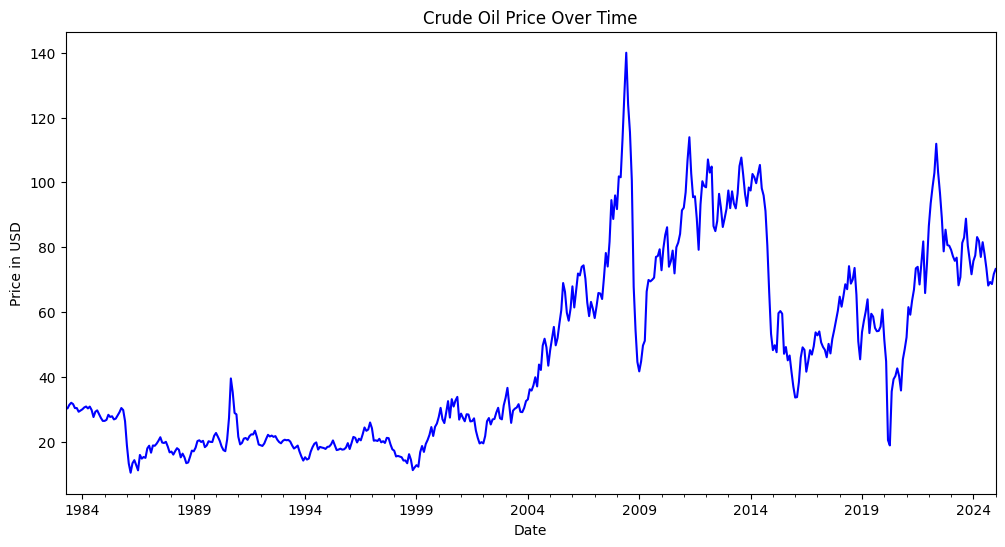

In [142]:
# Plot the time series
data['price'].plot(figsize=(12, 6), title='Crude Oil Price Over Time', color='blue')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.show()

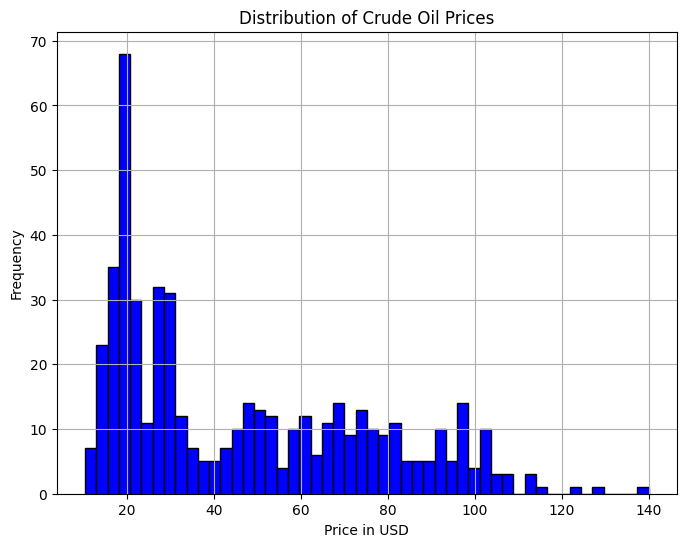

In [141]:
# Distribution of the price data
plt.figure(figsize=(8, 6))
data['price'].hist(bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Crude Oil Prices')
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.show()

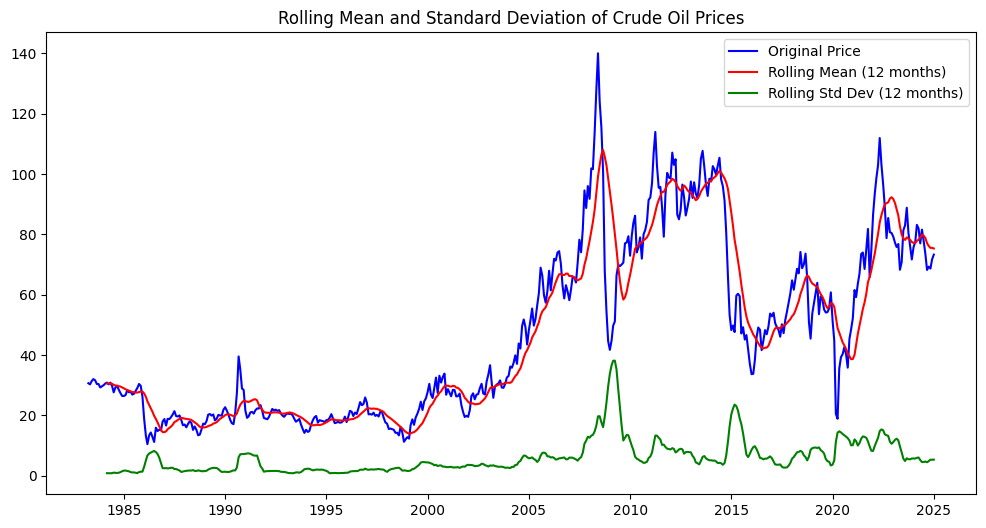

In [140]:
# Rolling mean and standard deviation
rolling_mean = data['price'].rolling(window=12).mean()
rolling_std = data['price'].rolling(window=12).std()
plt.figure(figsize=(12, 6))
plt.plot(data['price'], label='Original Price', color='blue')
plt.plot(rolling_mean, label='Rolling Mean (12 months)', color='red')
plt.plot(rolling_std, label='Rolling Std Dev (12 months)', color='green')
plt.title('Rolling Mean and Standard Deviation of Crude Oil Prices')
plt.legend()
plt.show()

## Split data Train dan Test

In [145]:
# Membagi data menjadi train dan test
train_size = int(len(data_with_features) * 0.8)
train, test = data_with_features[:train_size], data_with_features[train_size:]

X_train, y_train = train.drop('price', axis=1), train['price']
X_test, y_test = test.drop('price', axis=1), test['price']

## Seleksi Fitur

In [146]:
# Korelasi antara fitur dan target
correlation = data_with_features.corr()

# Menampilkan fitur yang paling relevan dengan target
print(correlation['price'].sort_values(ascending=False))

price            1.000000
lag_1            0.985401
lag_2            0.964829
lag_3            0.942939
lag_4            0.921073
lag_5            0.901348
change           0.088771
percentChange    0.060701
Name: price, dtype: float64


In [147]:
# Membuat model dasar
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Membuat objek RFE
rfe = RFE(model, n_features_to_select=5)
X_train_selected = rfe.fit_transform(X_train, y_train)

# Menampilkan fitur terpilih
selected_features = X_train.columns[rfe.support_]
print(f'Selected Features: {selected_features}')


Selected Features: Index(['percentChange', 'change', 'lag_1', 'lag_2', 'lag_3'], dtype='object')


##  Pelatihan Model

In [148]:
class SklearnCompatibleXGBRegressor(XGBRegressor, BaseEstimator, RegressorMixin):pass

# Gunakan model baru
model = SklearnCompatibleXGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

In [149]:
# Melatih model
model.fit(X_train, y_train)
# Melakukan prediksi
predictions = model.predict(X_test)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (397, 7)
Shape of y_train: (397,)


## Evaluasi Model

In [150]:
# Evaluasi model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')

RMSE: 3.1878962476934483
MAE: 2.086737221618652
R-squared: 0.9649909219811134


## Visualisasi

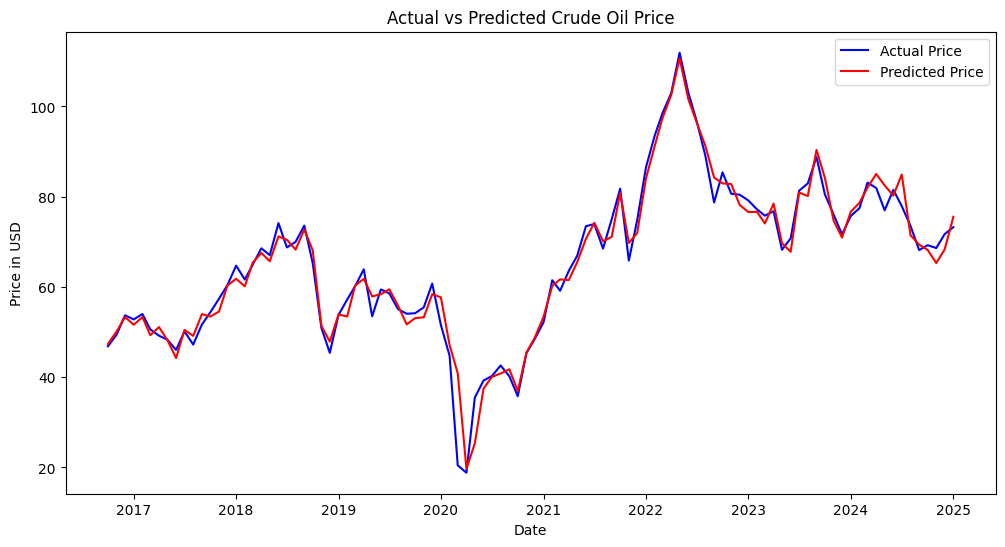

In [151]:
# Plot hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual Price', color='blue')
plt.plot(test.index, predictions, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Crude Oil Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()